<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week5/p044035_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [12]:
# ========================
# 1. 데이터 로딩 함수 (동일)
# ========================
def load_signals_from_mat(mat_path):
    """MATLAB .mat 파일에서 PPG 신호와 SBP, DBP 값을 로드합니다."""
    signals = {'ppg': [], 'sbp': [], 'dbp': []}
    with h5py.File(mat_path, 'r') as f:
        subj_wins = f['Subj_Wins']
        ppg_refs = subj_wins['PPG_F'][0]
        sbp_refs = subj_wins['SegSBP'][0]
        dbp_refs = subj_wins['SegDBP'][0]

        num_samples = min(len(ppg_refs), 1600)

        for i in range(num_samples):
            signals['ppg'].append(f[ppg_refs[i]][()].squeeze().astype(np.float32))
            signals['sbp'].append(float(f[sbp_refs[i]][()][0, 0]))
            signals['dbp'].append(float(f[dbp_refs[i]][()][0, 0]))
    return signals

In [13]:
# ========================
# 2. 시각화 함수들 (샘플 시각화 추가)
# ========================
def plot_sample_signal(signals, sample_idx=0):
    """분석 시작 전, 단일 샘플의 신호를 시각화합니다."""
    ppg = signals['ppg'][sample_idx]
    sbp = signals['sbp'][sample_idx]
    dbp = signals['dbp'][sample_idx]

    plt.figure(figsize=(12, 5))
    plt.plot(ppg, label=f'PPG Signal (Sample {sample_idx})', color='blue')
    plt.title(f'Sample {sample_idx} Data Visualization')
    plt.xlabel('Time Steps')
    plt.ylabel('PPG Amplitude')
    plt.text(0.98, 0.95, f'SBP: {sbp:.1f} mmHg\nDBP: {dbp:.1f} mmHg',
             ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.8))
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_learning_curves(history, fold_num):
    """각 Fold의 학습/검증 손실 곡선을 시각화합니다."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Learning Curves (Loss over Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_overall_regression_results(y_true, y_pred):
    """모든 Fold의 결과를 종합하여 회귀 성능을 시각화합니다."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Overall Model Performance (All Folds Combined)', fontsize=16, fontweight='bold')

    # SBP 분석
    sbp_true, sbp_pred = y_true[:, 0], y_pred[:, 0]
    sbp_residuals = sbp_true - sbp_pred
    axes[0, 0].scatter(sbp_true, sbp_pred, alpha=0.5, edgecolors='k', c='royalblue')
    axes[0, 0].plot([min(sbp_true), max(sbp_true)], [min(sbp_true), max(sbp_true)], 'r--', lw=2, label='y=x (Ideal)')
    axes[0, 0].set_title('SBP: Predicted vs. Actual Values'), axes[0, 0].set_xlabel('Actual SBP (mmHg)'), axes[0, 0].set_ylabel('Predicted SBP (mmHg)'), axes[0, 0].grid(True), axes[0, 0].legend()
    axes[0, 1].scatter(sbp_pred, sbp_residuals, alpha=0.5, edgecolors='k', c='coral')
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_title('SBP: Residuals vs. Predicted Values'), axes[0, 1].set_xlabel('Predicted SBP (mmHg)'), axes[0, 1].set_ylabel('Residuals (Actual - Predicted)'), axes[0, 1].grid(True)

    # DBP 분석
    dbp_true, dbp_pred = y_true[:, 1], y_pred[:, 1]
    dbp_residuals = dbp_true - dbp_pred
    axes[1, 0].scatter(dbp_true, dbp_pred, alpha=0.5, edgecolors='k', c='mediumseagreen')
    axes[1, 0].plot([min(dbp_true), max(dbp_true)], [min(dbp_true), max(dbp_true)], 'r--', lw=2, label='y=x (Ideal)')
    axes[1, 0].set_title('DBP: Predicted vs. Actual Values'), axes[1, 0].set_xlabel('Actual DBP (mmHg)'), axes[1, 0].set_ylabel('Predicted DBP (mmHg)'), axes[1, 0].grid(True), axes[1, 0].legend()
    axes[1, 1].scatter(dbp_pred, dbp_residuals, alpha=0.5, edgecolors='k', c='orchid')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_title('DBP: Residuals vs. Predicted Values'), axes[1, 1].set_xlabel('Predicted DBP (mmHg)'), axes[1, 1].set_ylabel('Residuals (Actual - Predicted)'), axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [14]:
# ========================
# 3. PyTorch 모델 정의 (CNN-LSTM 추가)
# ========================
class Conv1DNet(nn.Module): # 기존 CNN 모델 (비교용)
    def __init__(self, input_channels=1):
        super(Conv1DNet, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2))
        self.conv_block2 = nn.Sequential(nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2))
        self.conv_block3 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2), nn.ReLU())
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_block = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 2))
    def forward(self, x):
        x = self.conv_block1(x); x = self.conv_block2(x); x = self.conv_block3(x); x = self.global_pool(x)
        x = x.view(x.size(0), -1); x = self.fc_block(x)
        return x

class Conv1DLSTMNet(nn.Module): # 신규 CNN-LSTM 모델
    def __init__(self, input_channels=1, lstm_hidden_size=64):
        super(Conv1DLSTMNet, self).__init__()
        # CNN Feature Extractor
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # LSTM
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        # Fully Connected Layer
        self.fc_block = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 64), # Bidirectional이라 *2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        # CNN: (Batch, Channels, Length) -> (Batch, CNN_out_channels, Reduced_Length)
        x = self.cnn_extractor(x)
        # LSTM을 위한 차원 변경: (Batch, Channels, Length) -> (Batch, Length, Channels)
        x = x.permute(0, 2, 1)
        # LSTM: (Batch, Seq_len, Features)
        lstm_out, _ = self.lstm(x)
        # 마지막 time step의 hidden state만 사용
        last_hidden_state = lstm_out[:, -1, :]
        # FC Layer
        output = self.fc_block(last_hidden_state)
        return output


In [15]:
# ========================
# 4. 메인 실행 블록
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
mat_path = '/content/drive/MyDrive/Colab Notebooks/p044036.mat'
all_signals = load_signals_from_mat(mat_path)

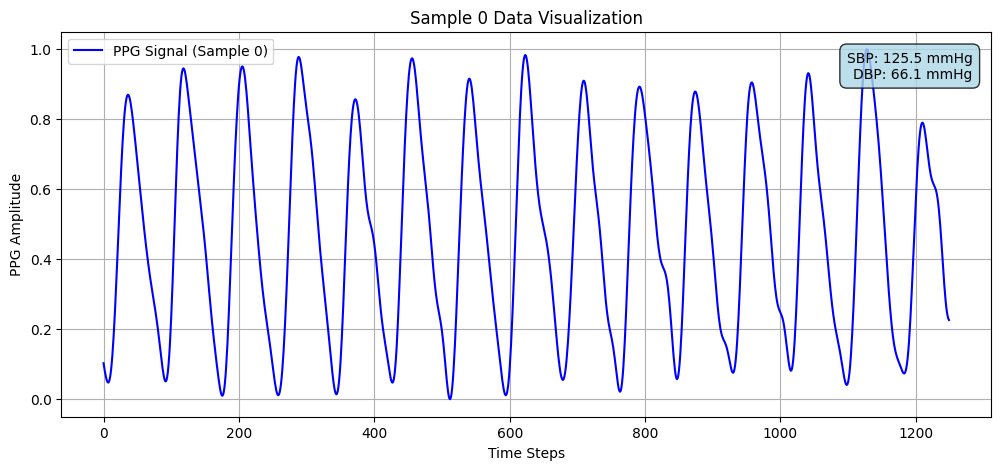

In [17]:
# ====== 분석 시작 전 샘플 시각화 추가 ======
plot_sample_signal(all_signals, sample_idx=0)

In [18]:
X_np, Y_np = np.array(all_signals['ppg']), np.array(list(zip(all_signals['sbp'], all_signals['dbp'])), dtype=np.float32)
X_np = np.expand_dims(X_np, axis=1)

print(f"Data loaded: X shape={X_np.shape}, Y shape={Y_np.shape}")

Data loaded: X shape=(1600, 1, 1250), Y shape=(1600, 2)


In [19]:
n_splits, fold_size = 4, len(X_np) // 4
test_size, train_val_size = 100, fold_size - 100

sbp_maes, dbp_maes = [], []
all_y_true, all_y_pred = [], []


===== Fold 1/4 Start =====


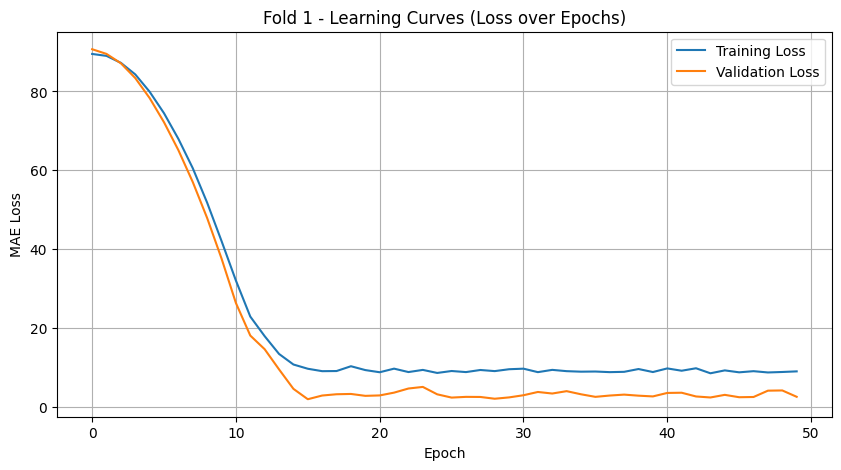

Model training completed.
Fold 1 Result: SBP MAE = 7.95, DBP MAE = 2.18

===== Fold 2/4 Start =====


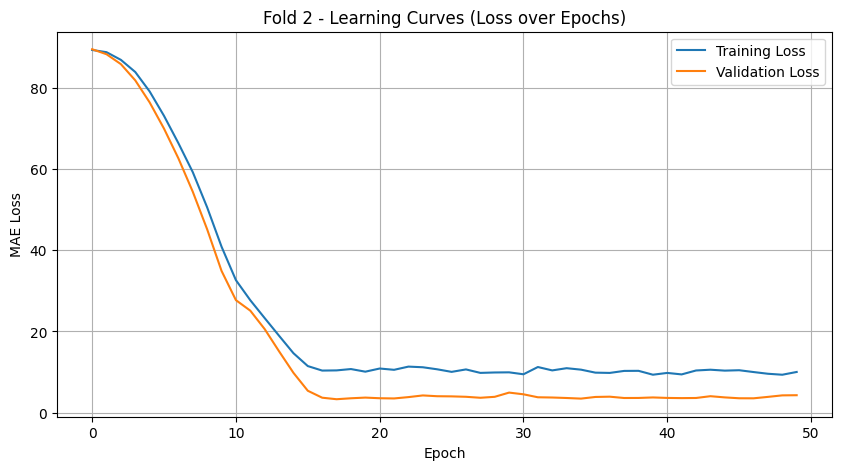

Model training completed.
Fold 2 Result: SBP MAE = 8.62, DBP MAE = 3.48

===== Fold 3/4 Start =====


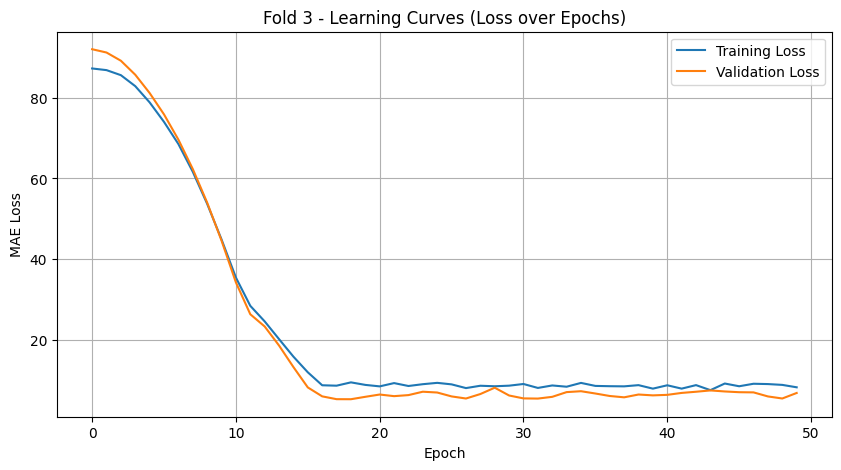

Model training completed.
Fold 3 Result: SBP MAE = 10.26, DBP MAE = 4.45

===== Fold 4/4 Start =====


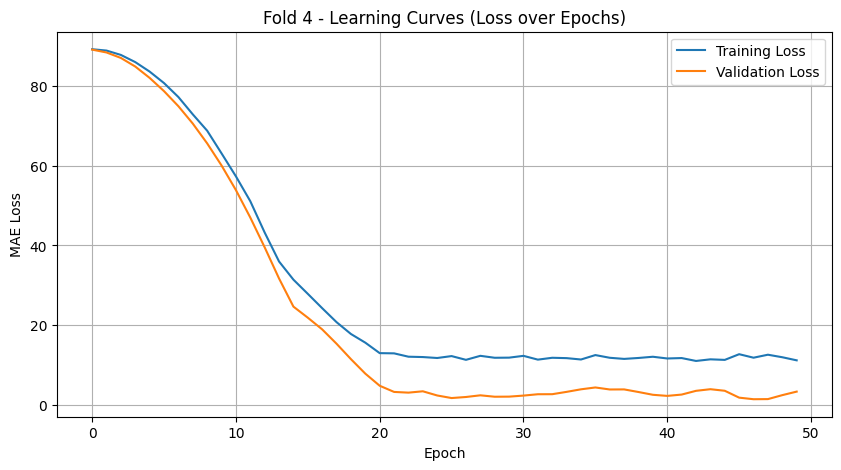

Model training completed.
Fold 4 Result: SBP MAE = 7.64, DBP MAE = 4.74


In [20]:
for i in range(n_splits):
    print(f"\n===== Fold {i+1}/{n_splits} Start =====")

    start_idx = i * fold_size
    train_val_end_idx, test_end_idx = start_idx + train_val_size, start_idx + fold_size
    X_train_val_fold, Y_train_val_fold = X_np[start_idx:train_val_end_idx], Y_np[start_idx:train_val_end_idx]
    X_test_fold, Y_test_fold = X_np[train_val_end_idx:test_end_idx], Y_np[train_val_end_idx:test_end_idx]

    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val_fold, Y_train_val_fold, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_fold.reshape(-1, 1)).reshape(X_test_fold.shape)

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(Y_train).float()), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled).float(), torch.from_numpy(Y_val).float()), batch_size=32)

    # ====== 사용할 모델 선택 ======
    # model = Conv1DNet().to(device) # 기존 CNN 모델
    model = Conv1DLSTMNet().to(device) # 새로운 CNN-LSTM 모델

    criterion, optimizer = nn.L1Loss(), torch.optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(50):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()

        history['train_loss'].append(epoch_train_loss / len(train_loader))
        history['val_loss'].append(epoch_val_loss / len(val_loader))

    plot_learning_curves(history, fold_num=i+1)
    print("Model training completed.")

    model.eval()
    with torch.no_grad():
        Y_pred_fold = model(torch.from_numpy(X_test_scaled).float().to(device)).cpu().numpy()

    sbp_maes.append(mean_absolute_error(Y_test_fold[:, 0], Y_pred_fold[:, 0]))
    dbp_maes.append(mean_absolute_error(Y_test_fold[:, 1], Y_pred_fold[:, 1]))
    print(f"Fold {i+1} Result: SBP MAE = {sbp_maes[-1]:.2f}, DBP MAE = {dbp_maes[-1]:.2f}")

    all_y_true.append(Y_test_fold)
    all_y_pred.append(Y_pred_fold)

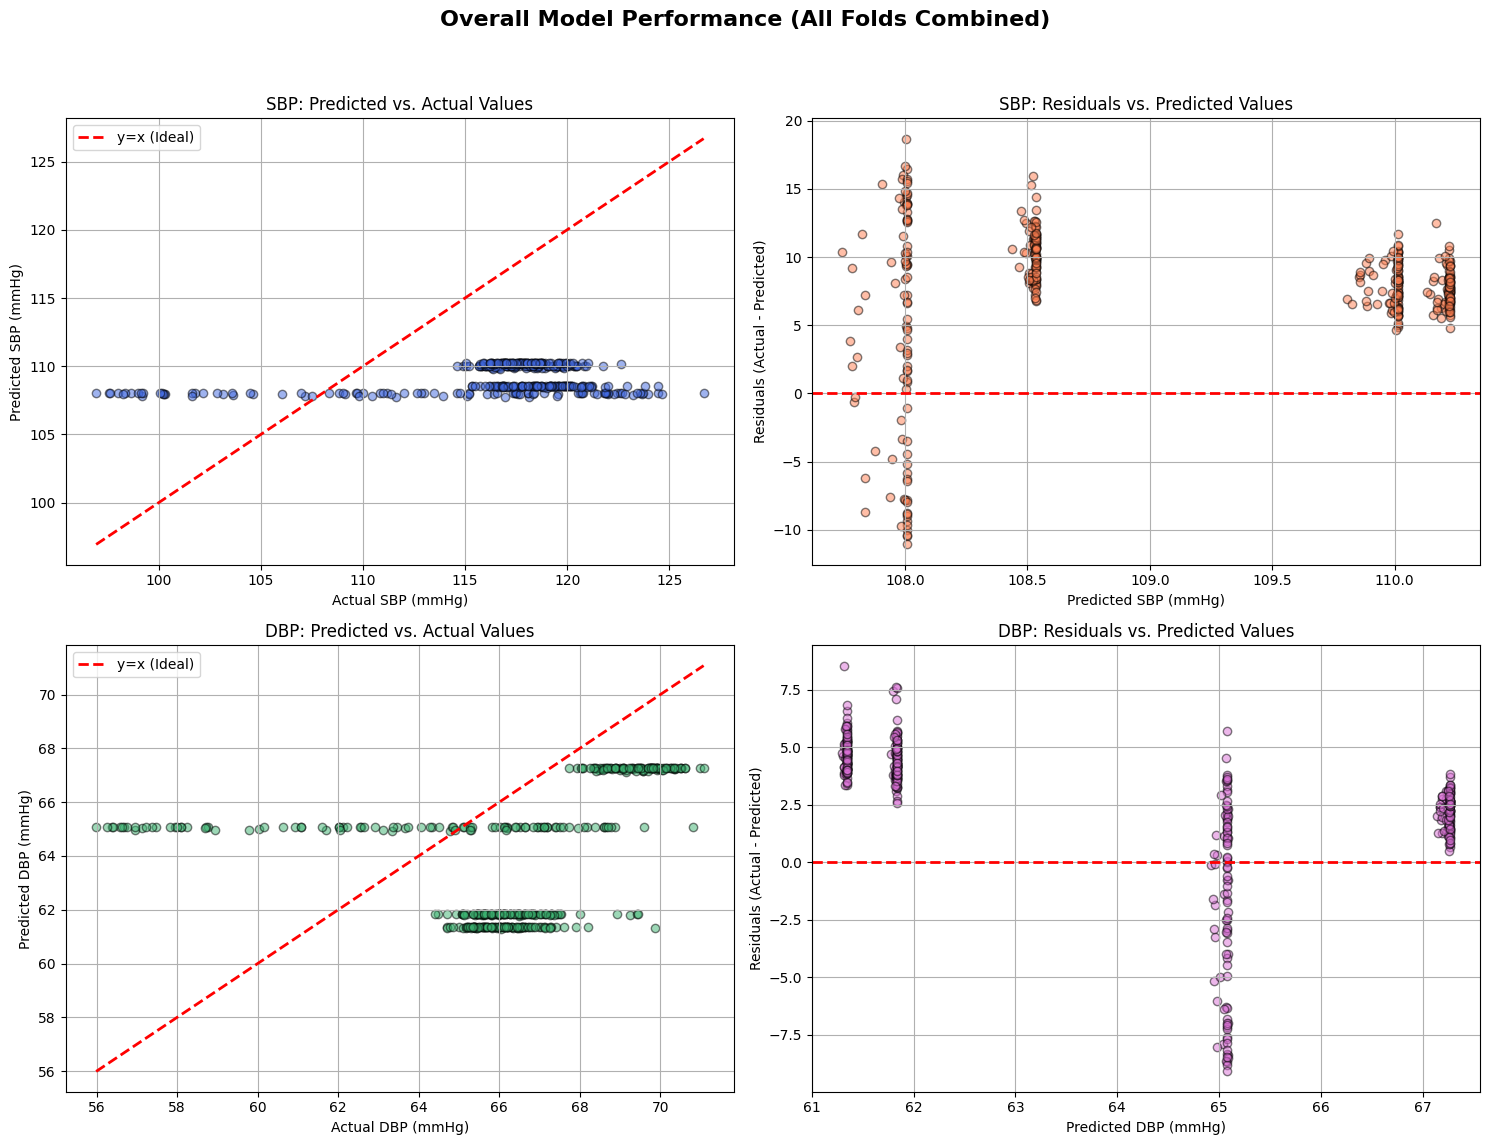


===== Final Results =====
Average SBP MAE: 8.62 ± 1.01
Average DBP MAE: 3.71 ± 1.00


In [21]:
final_y_true = np.concatenate(all_y_true)
final_y_pred = np.concatenate(all_y_pred)
plot_overall_regression_results(final_y_true, final_y_pred)

print("\n===== Final Results =====")
print(f"Average SBP MAE: {np.mean(sbp_maes):.2f} ± {np.std(sbp_maes):.2f}")
print(f"Average DBP MAE: {np.mean(dbp_maes):.2f} ± {np.std(dbp_maes):.2f}")